In [4]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [9]:
# load the data
xau23 = pd.read_csv("./data/xau23.csv", header=None)
xau22 = pd.read_csv("./data/xau22.csv", header=None)
xau21 = pd.read_csv("./data/xau21.csv", header=None)

# create a columns name
cname= ["date","sec","open", "high", "low", "close","volume"]
xau23.columns = cname
xau22.columns = cname
xau21.columns = cname

# union the data set 
xau_data = pd.concat([xau23,xau22,xau21])
print(xau_data.head())

# Check for N/A
print(xau_data.isna().sum())
# Check for types
print(xau_data.dtypes)

# combine the date and time columns into a single string
xau_data['datetime'] = xau_data['date'] + xau_data['sec']

# convert the combined string to a Pandas datetime object
xau_data['datetime'] = pd.to_datetime(xau_data['datetime'], format = '%Y.%m.%d%H:%M')

# reselect the data
xau_data = xau_data[['datetime','open','high','low','close','volume']]

# sort the data ascending
xau_data = xau_data.sort_values(by='datetime',ascending=True)

print(xau_data.dtypes)

# set the datetime column as the index
xau_data.set_index('datetime', inplace=True)

# resample data into 1hour interval
xau_data = xau_data.resample('1H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last','volume':'sum'})

print(xau_data.isnull().sum())

# drop null value (Market Close on those days)
xau_data = xau_data.dropna()
print(xau_data.isnull().sum())

print(len(xau_data))
print(xau_data.head())


#### Adding shift windows
# targets, check the highest gold price attained in the next 4 hours
df = xau_data
highs = df['high'].rolling(window=4).max().shift(-4)
lows = df['low'].rolling(window=4).min().shift(-4)

# create new columns for conditions
df['high_close_diff'] = highs - df['close'].shift(1)
df['low_close_diff'] = lows - df['close'].shift(1)

df = df.dropna()

         date    sec      open      high       low     close  volume
0  2023.01.02  18:00  1826.837  1827.337  1826.617  1826.637       0
1  2023.01.02  18:01  1826.537  1827.357  1826.137  1826.537       0
2  2023.01.02  18:02  1826.137  1826.737  1826.137  1826.737       0
3  2023.01.02  18:05  1827.187  1828.867  1827.187  1828.738       0
4  2023.01.02  18:06  1828.758  1829.958  1828.758  1829.497       0
date      0
sec       0
open      0
high      0
low       0
close     0
volume    0
dtype: int64
date       object
sec        object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object
datetime    datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume               int64
dtype: object
open      6170
high      6170
low       6170
close     6170
volume       0
dtype: int64
open      0
high      0
low       0
close     0
volume    0
dtype: int64
12700
      

In [10]:
def reco(row):
    if row.high_close_diff >= 3.3: 
        return 0
    elif row.low_close_diff <= -4.3:#I use 3 plus .3 for bit offer off-set, and 1 in case of delay ordering cause price to change.
        return 1
    else:
        return 0

df['target'] = df.apply(reco,axis=1)


print('1', (df['target'] == 1).sum())
print('0', (df['target'] == 0).sum())

df_simu = df
df = df[['open','high','low','close','target']]

1 3832
0 8863


C:\Users\pkong\AppData\Local\Temp\ipykernel_18468\1888599090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df.apply(reco,axis=1)


In [70]:
n = len(df)
print(n)

train_n = int(round(n*0.65,0))
print('number of training set: ', train_n)

cross_n = int(round(n*0.20,0))
print('number of cross validation set: ', cross_n)

test_n = int(round(n*0.15-1,0))
print('number of test set: ', test_n)

print('sum', train_n + cross_n + test_n)


train_start = str(df.iloc[0].name)
train_end = str(df.iloc[train_n].name)
print('Training set start: {0} \n Training set end: {1}'.format(train_start,train_end))
#print(df.loc[train_start:train_end])

cross_start = str(df.iloc[train_n+1].name)
cross_end = str(df.iloc[train_n+cross_n].name)
print('cross validation set start: {0} \n cross validation set end: {1}'.format(cross_start,cross_end))
#print(df.loc[cross_start:cross_end])

test_start = str(df.iloc[train_n + cross_n +1].name)
test_end = str(df.iloc[n-1].name)
print('test set start: {0} \n test set end: {1}'.format(test_start,test_end))
#print(df.loc[test_start:])

X = df.drop(['target'], axis=1)

y = df['target']


X_train = np.asarray(X.loc[train_start:train_end])
y_train = np.asarray(y.loc[train_start:train_end])

X_cross = np.asarray(X.loc[cross_start:cross_end])
y_cross = np.asarray(y.loc[cross_start:cross_end])

X_test = np.asarray(X.loc[test_start:])
y_test =np.asarray(y.loc[test_start:])



#Extra for GridSearch
X_train_cv = np.asarray(X.loc[train_start:cross_end])
y_train_cv = np.asarray(y.loc[train_start:cross_end])


X_train.shape, y_train.shape, X_cross.shape, y_cross.shape, X_test.shape, y_test.shape, X_train_cv.shape, y_train_cv.shape


# Below is for later simulation
df_simu_test = df_simu.loc[test_start:]

12695
number of training set:  8252
number of cross validation set:  2539
number of test set:  1903
sum 12694
Training set start: 2021-01-03 19:00:00 
 Training set end: 2022-05-26 18:00:00
cross validation set start: 2022-05-26 19:00:00 
 cross validation set end: 2022-10-28 11:00:00
test set start: 2022-10-28 12:00:00 
 test set end: 2023-02-28 19:00:00


In [63]:
y_test.shape

(1903,)

In [12]:
#Create Normalized Data
def normalize_data(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_norm = (X - means) / stds
    return X_norm, means, stds

#This can run multiple times
X_train_n, X_train_means, X_train_stds = normalize_data(X_train)

def normalize_data_new(X,means,stds):
    X_norm = (X - means) / stds
    return X_norm

X_cross_n = normalize_data_new(X_cross,X_train_means,X_train_stds)
X_test_n = normalize_data_new(X_test,X_train_means,X_train_stds)

C=0.01, Train score=0.7100448321822368, cross score=0.6734935013784955
C=0.1, Train score=0.747364594692839, cross score=0.7046081134304845
C=0.5, Train score=0.7657821398279413, cross score=0.7306025994486018
C=1, Train score=0.7692960135708228, cross score=0.7349350137849547
C=1.5, Train score=0.770386526111717, cross score=0.7376920047262702
C=2, Train score=0.7711135344723131, cross score=0.7388735722725482
C=10, Train score=0.7713558705925118, cross score=0.7432059866089011
The best 'C' is: 10
score: 0.74
Accuracy_score:  0.74
weight avg 0.7
jaccard:  0.28
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1705
           1       0.79      0.30      0.43       834

    accuracy                           0.74      2539
   macro avg       0.76      0.63      0.63      2539
weighted avg       0.75      0.74      0.70      2539



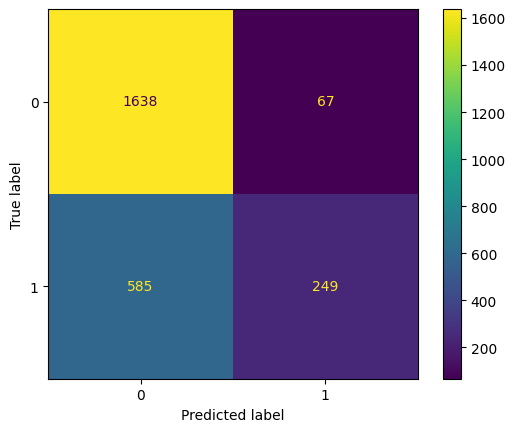

In [13]:
# Define a list of hyperparameters to loop through
#################larger value of C imposes less regularization on the model
Cs = [0.01, 0.1,0.5, 1, 1.5, 2, 10]

# Initialize variables to keep track of the best hyperparameters and their corresponding score
best_score = 0
best_C = None
max_iter = 20000
features_X_train = X_train_n
target_y_train = y_train
features_X_cross = X_cross_n
target_y_cross = y_cross
# Loop through the hyperparameters
for C in Cs:
    lsvm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=C, max_iter=max_iter)
    lsvm.fit(X_train_n, y_train)
    train_score = lsvm.score(features_X_train, target_y_train)
    cross_score = lsvm.score(features_X_cross, target_y_cross)
    print(f"C={C}, Train score={train_score}, cross score={cross_score}")
    
    # Update the best hyperparameters and their corresponding score if applicable
    if train_score > best_score:
        best_score = train_score
        best_C = C

print("The best 'C' is:", best_C)
# Create the LinearSVC model with normalization and the best value of C
lsvm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=best_C, max_iter=max_iter)

# Fit the model to the training data
lsvm.fit(features_X_train, target_y_train)


#EVALUATION
test_score = round(lsvm.score(features_X_cross, target_y_cross),2)
print("score:", test_score)


yhat_m1 = lsvm.predict(features_X_cross)
accuracy_m1 = round(accuracy_score(target_y_cross,yhat_m1),2)
print('Accuracy_score: ', accuracy_m1)

f1 = round(f1_score(target_y_cross, yhat_m1, average='weighted'), 2)
print('weight avg', f1)

jaccard = round(jaccard_score(target_y_cross, yhat_m1,pos_label=1),2)
print('jaccard: ', jaccard)

print(metrics.classification_report(target_y_cross, yhat_m1))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(lsvm, features_X_cross, target_y_cross)


In [93]:
X_test_simu = X.loc[test_start:]
X_test_simu_n = normalize_data_new(X_test_simu,X_train_means,X_train_stds)

X_cross_simu = X.loc[cross_start:cross_end]
X_cross_simu_n = normalize_data_new(X_cross_simu,X_train_means,X_train_stds)

def predict_count(data_simu):
    adding = []
    for i in range(0,len(data_simu)):
        prediction = str(lsvm.predict(data_simu.iloc[i].values.reshape(1,-1))).strip('[]')
        adding.append(prediction)
    print(adding.count('0'))
    print(adding.count('1'))


print('-----cross-----')
print('The value should be:>> yhat = 0: {0}<<, >> yhat = 1: {1}<<'.format(np.count_nonzero(yhat_m1 == 0),np.count_nonzero(yhat_m1 == 1)))
predict_count(X_cross_simu_n)

print('-----test-----')
predict_count(X_test_simu_n)

-----cross-----
The value should be:>> yhat = 0: 2223<<, >> yhat = 1: 316<<
2223
316
-----test-----
1649
254


In [65]:
X_test_simu_n.shape

(1903, 4)

In [15]:
def predict_simu(model, data_simu_x_n, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(data_simu_x_n)):
        prediction = model.predict(data_simu_x_n.iloc[i].values.reshape(1,-1))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(data_simu_x_n.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max


In [104]:
win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max = predict_simu(lsvm, X_test_simu_n, y_test, 500)                                                          
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n.iloc[len(X_test_simu_n)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))

Total Return: 74.0%
Final Capital: $871.0
Win Count:  192
Lost Count:  62
No Order Count:  1649
Max Consecutive Lost: 4.0 trades
Total day on trading: 123 days


# Export the simulation data set:

In [100]:
np.savetxt('y_short_simu.csv', y_test, delimiter=',')
X_test_simu_n.to_csv('X_short_simu.csv')

##### To import the file use:

```python
y_test = np.loadtxt('y_short_simu.csv', delimiter=',')
X_test_simu_n = pd.read_csv('X_short_simu.csv',index_col='datetime', parse_dates=True)
```

<Axes: xlabel='record_date'>

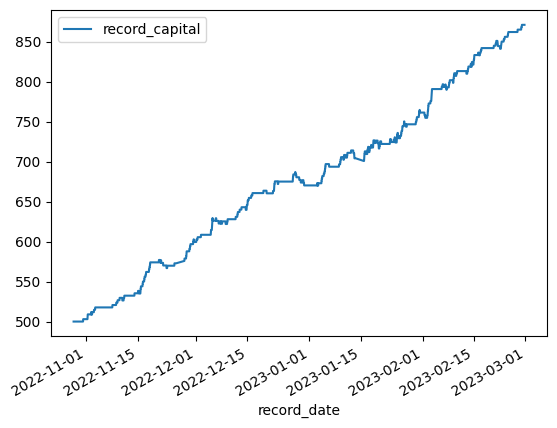

In [23]:
sim_df.plot(y='record_capital')

# Saving model using Pickle

In [20]:
import pickle
print('version should be 4.0:',pickle.format_version)
pickle.dump(lsvm,open('lsvm_xauusd_short.pkl','wb'))

version should be 4.0: 4.0


In [21]:
pickled_model=pickle.load(open('lsvm_xauusd_short.pkl','rb'))

In [22]:
model_input = [-2.839808,-2.806494,-2.828501,-2.791640]
model_input = np.array(model_input).reshape(1,-1)
model_input
pickled_model.predict(model_input)

array([0], dtype=int64)